## 必要なライブラリのインポート
- numpy,chainer系
- ファイル操作系
- 画像操作
- 転移学習のためのライブラリ(caffeモデル扱うやつ)

In [1]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import iterators, optimizers, training
from chainer.training import extensions
from chainer.cuda import to_cpu
from chainer import cuda

import os
import glob
from PIL import Image

from chainer.links.caffe import CaffeFunction
import _pickle as pickle

## modelの定義(AlexNetぽい構造の何か)

In [2]:
# class AlexNet(chainer.Chain):
# #     insize = 100
#     def __init__(self):
#         super(AlexNet, self).__init__(
#             conv1=L.Convolution2D(3, 96, 11, stride=4),
#             conv2=L.Convolution2D(96, 256, 5, pad=2),
#             conv3=L.Convolution2D(256, 384, 3, pad=1),
#             conv4=L.Convolution2D(384, 284, 3, pad=1),
#             conv5=L.Convolution2D(284, 256, 3, pad=1),
#             fc6=L.Linear(1024, 4096),
#             fc7=L.Linear(4096, 1024),
#             fc8=L.Linear(1024, 3),
#         )

#     def __call__(self, x, t=None):
#         h = x
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
#         h = F.relu(self.conv3(h))
#         h = F.relu(self.conv4(h))
#         h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
#         h = F.dropout(F.relu(self.fc6(h)))
#         h = F.dropout(F.relu(self.fc7(h)))
#         if t is not None:
#             loss = F.softmax_cross_entropy(h, t)
#             chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
#             return loss
#         else:
#             return to_cpu(F.softmax(self.fc8(h)).data)

In [3]:
class AlexNet(chainer.Chain):
#     insize = 100
    def __init__(self):
        super(AlexNet, self).__init__(
            conv1=L.Convolution2D(3, 96, 11, stride=4),
            conv2=L.Convolution2D(96, 256, 5, pad=2),
            conv3=L.Convolution2D(256, 384, 3, pad=1),
            conv4=L.Convolution2D(384, 384, 3, pad=1),
            conv5=L.Convolution2D(384, 256, 3, pad=1),
            my_fc6=L.Linear(9216, 4096),
            my_fc7=L.Linear(4096, 1024),
            my_fc8=L.Linear(1024, 3),
        )

    def __call__(self, x, t=None):
        h = x
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.my_fc6(h)))
        h = F.dropout(F.relu(self.my_fc7(h)))
        if t is not None:
            loss = F.softmax_cross_entropy(h, t)
            chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
            return loss
        else:
            return to_cpu(F.softmax(self.my_fc8(h)).data)

## データセットのディレクトリ名の取得
以降、ディレクトリごとにラベルつけていく

In [4]:
dataset_dir = "dataset"
# label_names = os.listdir(dataset_dir)
label_names = ["105-1", "445-0", "798-0"]

In [5]:
# label_names = label_names[0:3]

In [6]:
_labels = []
_images = []

In [7]:
for i, label in enumerate(label_names):
    for f in glob.glob("%s/%s/*"%(dataset_dir,label)):
        img = Image.open(f)
        img = np.array(img.resize((227,227)))
        for j in range(10):
            _labels.append(i)
            _images.append(img)

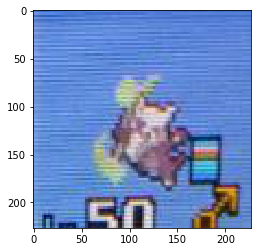

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(_images[0])

In [9]:
# 正規化
images = np.array(_images, dtype=np.float32) / 255.0
labels = np.array(_labels, dtype=np.int32)

## chainerで扱えるようにRGBの層を手前に持ってくる

In [10]:
images = images.transpose(0,3,1,2)

In [11]:
images[0].shape
labels.shape

(210,)

## 画像と正解ラベルのペアを作成する

In [12]:
x_train = chainer.datasets.TupleDataset(images, labels)

In [13]:
x_train[0]

(array([[[ 0.33725491,  0.33725491,  0.31764707, ...,  0.26666668,
           0.26274511,  0.26274511],
         [ 0.33725491,  0.33725491,  0.31764707, ...,  0.26666668,
           0.26274511,  0.26274511],
         [ 0.44313726,  0.44313726,  0.41568628, ...,  0.32156864,
           0.31764707,  0.31764707],
         ..., 
         [ 0.38039216,  0.38039216,  0.41176471, ...,  0.40784314,
           0.41176471,  0.41176471],
         [ 0.50588238,  0.50588238,  0.52941179, ...,  0.40000001,
           0.40784314,  0.40784314],
         [ 0.50588238,  0.50588238,  0.52941179, ...,  0.40000001,
           0.40784314,  0.40784314]],
 
        [[ 0.49803922,  0.49803922,  0.47450981, ...,  0.43921569,
           0.43529412,  0.43529412],
         [ 0.49803922,  0.49803922,  0.47450981, ...,  0.43921569,
           0.43529412,  0.43529412],
         [ 0.59215689,  0.59215689,  0.57647061, ...,  0.49411765,
           0.49019608,  0.49019608],
         ..., 
         [ 0.53333336,  0.53333

## 入力に渡すiteratorの作成

In [14]:
train_iter = iterators.SerialIterator(x_train, batch_size=30, shuffle=True)

## AlexNetの学習済みcaffeモデルの読み込みとpickleファイルの保存

In [15]:
# alexnet = CaffeFunction("bvlc_alexnet.caffemodel")

In [16]:
# pickle.dump(alexnet, open("./chainermodels/alexnet.pkl", 'wb'))

## モデルの重みをコピーするための関数

In [17]:
def copy_model(src, dst):
    assert isinstance(src, chainer.Chain)
    assert isinstance(src, chainer.Chain)
    for child in src.children():
        if child.name not in dst.__dict__: continue
        dst_child = dst[child.name]
        if type(child) != type(dst_child): continue
        if isinstance(child, chainer.Chain):
            copy_model(child, dst_child)
        if isinstance(child, chainer.Link):
            match = True
            for a, b in zip(child.namedparams(), dst_child.namedparams()):
                if a[0] != b[0]:
                    match = False
                    break
                if a[1].data.shape != b[1].data.shape:
                    match = False
                    break
                if not match:
                    print('Ignore %s because of parameter mismatch' % child.name)
                    continue
                for a, b in zip (child.namedparams(), dst_child.namedparams()):
                    b[1].data = a[1].data
                    print('Copy %s' % child.name)
            

## modelの作成

In [18]:
model = AlexNet()

In [19]:
# trained_model = pickle.load(open("./chainermodels/alexnet.pkl", "rb"))

## modelの重みをコピー

In [20]:
# copy_model(trained_model, model)

In [21]:
model.my_fc8.W.shape

(3, 1024)

In [22]:
# trained_model.fc8.W.shape

## 重みとバイアスを固定するための関数

In [23]:
class DelGradient(object):
    name = 'DelGradient'
    def __init__(self, delTgt):
        self.delTgt = delTgt

    def __call__(self, opt):
        for name,param in opt.target.namedparams():
            for d in self.delTgt:
                if d in name:
                    grad = param.grad
                    with cuda.get_device(grad):
                        grad *= 0

## 最適化手法の選択

In [24]:
optimizer = optimizers.Adam()
optimizer.setup(model)
# optimizer.add_hook(DelGradient(["conv1", "conv2", "conv3", "conv4", "conv5"]))

## undaterとtrainerの作成
device=0で処理が0番GPUに投げられるはず  
訓練結果はresultディレクトリに作成されるはず

In [25]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

/home/c0115334ef/anaconda3/lib/python3.6/site-packages/chainer/cuda.py:84: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cupy-with-cudnn-and-nccl).
  'cuDNN is not enabled.\n'


In [26]:
trainer = training.Trainer(updater, (100, 'epoch'), out='result')

## Logの出力設定

In [27]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss']))
trainer.extend(extensions.ProgressBar())

In [28]:
trainer.run()

epoch       main/accuracy  main/loss 
1           0.261905       7.86346     
2           0.309524       6.03965     
3           0.347619       5.53524     
4           0.333333       5.34913     
5           0.319048       5.41455     
6           0.371429       4.76721     
7           0.361905       5.40091     
8           0.32381        5.48803     
9           0.347619       5.22943     
10          0.314286       5.41684     
11          0.32381        5.37676     
12          0.347619       5.26209     
13          0.357143       5.33777     
14          0.380952       4.99636     
     total [#######...........................................] 14.29%
this epoch [##############....................................] 28.57%
       100 iter, 14 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
15          0.390476       5.11611     
16          0.404762       4.82923     
17          0.352381       5.12559     
18          0.419048       4.73606     
19  

## テスト

true_label 0
network's output


array([[ 0.2521244 ,  0.29957822,  0.44829738]], dtype=float32)

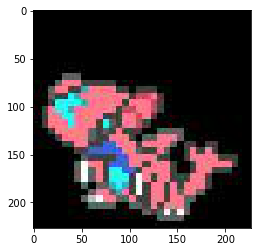

In [76]:
img, label = x_train[0]
model.train=False
cuda.check_cuda_available()
cuda.get_device(0).use()
xp = cuda.cupy
img = Image.open("./dataset/445-0.jpg").resize((227,227))
img = np.array(img, dtype=np.float32) / 255
img = img.transpose(2,0,1)
plt.imshow(img.transpose(1,2,0))

print("true_label",label)
print("network's output")
out = model(xp.asarray(img[None,:]))
out

In [62]:
# chainer.serializers.save_npz("20permodel.npz", model)